In [194]:
import threading
import functools
import string
import queue
import time
import json
import numpy as np
import pandas as pd
import pylab as pl
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture
from sklearn.neighbors import NearestNeighbors

import os

import requests
import bs4

In [8]:
def sort_dict(mydict):
    for k, v in mydict.items():
        if v is None:
            mydict[k] = 0
    return sorted(mydict.items(), key=lambda k: k[1], reverse=True)

In [74]:
def get_categories(links):
    S = requests.Session()
    URL = "https://en.wikipedia.org/w/api.php"
    categories = {}
    cat_names = set()
    for link in links:
        name = link[0].replace("/wiki/", "")
        name = name.replace("_", " ")
        PARAMS = {
          "action": "query",
          "format": "json",
          "titles": name,
          "prop": "categories"
        }

        response = S.get(url=URL, params=PARAMS).json()
        page = next(iter(response['query']['pages'].values()))
        L = []
        if ('categories' in page):
            for category in page['categories']:
                cat = category['title'].replace("Category:", "")
                L.append(cat)
                cat_names.add(cat)
            categories[name] = L
        
    return categories, cat_names

In [129]:
# tokenize all catagories and find how words connects
# remove a, an, the, as, of, from, at, with, people, to, who, in, under, for
# remove categories with 'Articles' or 'Wikidata'
def tokenize_categories(categories):
    trivial = ['a', 'an', 'the', 'as', 'of', 'from', 'at', 'with', 'people', 'to', 'who', 'in', 'under', 'for', '&', 'A', 'on', 'or', 'by']
    saved_categories = {}
    all_words = {} # map word with number of people with that word
    tokenized_categories = {}
    for name in categories:
        words = set()
        L = []
        for c in categories[name]:
            if 'Articles' not in c and 'Wikidata' not in c and 'CS1' not in c and 'Pages' not in c and 'articles' not in c and 'pages' not in c:
                cleaned_str = str(c).replace("(", " ").replace(")", " ").replace("'s", "").replace(" births", "-born").lower()
                words |= set(cleaned_str.split())
                L.append(c)
        for i in trivial:
            if i in words:
                words.remove(i)
        tokenized_categories[name] = [w for w in words]
        saved_categories[name] = L
        for w in words:
            if w in all_words:
                all_words[w] += 1
            else:
                all_words[w] = 1
        
    return tokenized_categories, all_words, saved_categories

In [114]:
def knn(one_hots, k=3):
    #pca = PCA(0.5)
    #one_hots = pca.fit_transform(one_hots)
    knn = NearestNeighbors(algorithm='kd_tree')
    knn.fit(one_hots)
    distances, indices = knn.kneighbors(one_hots, n_neighbors=k)
    zip_similar = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())))
    return np.array(zip_similar)

In [236]:
def get_closest_neighbors(knn_data, filename):
    #similar = pd.DataFrame([[name, ", ".join(map(str, saved_categories[name]))] for i, name in enumerate(list(tokenized_categories))])
    #similar.columns = ['name', 'categories']
    similar = pd.DataFrame([name for _, name in enumerate(list(tokenized_categories))])
    similar.columns = ['name']
    
    similar['most similar'] = '0'
    #similar['categories 1'] = '0'
    similar['distance 1'] = 0.000
    similar['second most similar'] = '0'
    #similar['categories 2'] = '0'
    similar['distance 2'] = 0.000
    for i in range(len(tokenized_categories)):
        each = knn_data[i]
        name1 = id2name[each[0][1]]
        similar.at[i, 'most similar'] = name1
        similar.at[i, 'distance 1'] = each[1][1]
        #similar['categories 1'] = ", ".join(map(str, saved_categories[name1]))
        name2 = id2name[each[0][2]]
        similar.at[i, 'second most similar'] = name2
        similar.at[i, 'distance 2'] = each[1][2]
        #similar['categories 2'] = ", ".join(map(str, saved_categories[name2]))
    similar.to_csv(filename)
    return similar

In [246]:
def plot_data(one_hots, filename):
    pca = PCA(n_components=2).fit(one_hots)
    pca_2d = pca.transform(one_hots)
    plt.scatter(pca_2d[:,0],pca_2d[:,1],c='black')
    plt.show()
    plt.savefig(filename)

In [57]:
with open('name-visit-count-all.json', 'r') as f:
    visit = json.load(f)

s = sort_dict(visit)

In [65]:
top = s[:10000]

In [75]:
# categories, cat_names = get_categories(top)

In [85]:
"""with open('categories.json', 'w') as f1:
    json.dump(categories, f1)
with open('category_names.txt', 'w', encoding='utf-8') as f2:
    for line in cat_names:
       f2.write(line+"\n")"""

In [125]:
with open('categories.json', 'r') as f1:
    categories = json.load(f1)

In [130]:
tokenized_categories, all_words, saved_categories = tokenize_categories(categories)

In [117]:
with open('tokenized_categories.json', 'w') as f1:
    json.dump(tokenized_categories, f1)
with open('all_words.json', 'w') as f2:
    json.dump(all_words, f2)

In [70]:
with open('tokenized_categories.json', 'r') as f1:
   tokenized_categories = json.load(f1)
with open('all_words.json', 'r') as f2:
    all_words = json.load(f2)

In [73]:
selected_words = {key:val for key, val in all_words.items() if val > 6}

In [74]:
print(len(selected_words))
print(sort_dict(selected_words))

1633
[('american', 5752), ('21st-century', 5023), ('20th-century', 4180), ('male', 3349), ('film', 2808), ('actors', 2413), ('descent', 2359), ('deaths', 2175), ('actresses', 2065), ('television', 2041), ('english', 1341), ('singers', 1337), ('alumni', 1333), ('living', 1242), ('women', 1193), ('writers', 1082), ('players', 1004), ('african-american', 924), ('united', 723), ('elements', 718), ('ac', 718), ('british', 699), ('child', 680), ('female', 668), ('indian', 637), ('musicians', 607), ('new', 606), ('states', 605), ('football', 576), ('comedians', 530), ('winners', 511), ('university', 506), ('world', 494), ('and', 491), ('stage', 482), ('irish', 477), ('german', 435), ('voice', 431), ('california', 429), ('york', 417), ('businesspeople', 415), ('artists', 404), ('italian', 401), ('award', 399), ('politicians', 382), ('college', 378), ('roman', 376), ('activists', 360), ('catholics', 344), ('producers', 342), ('cup', 340), ('academy', 330), ('guitarists', 329), ('school', 327), 

In [87]:
name2id = {name:i for i, name in enumerate(list(tokenized_categories))}
id2name = {i:name for i, name in enumerate(list(tokenized_categories))}

In [178]:
def prepare_data(tokenized_categories, vocab):
    word2id = {w:i for i, w in enumerate(list(vocab))}
    data = np.zeros((len(tokenized_categories), len(vocab)))
    for i, name in enumerate(tokenized_categories):
        for w in tokenized_categories[name]:
            if w in word2id:
                data[name2id[name], word2id[w]] = 1
    return data

In [192]:
tokenized_one_hots = prepare_data(tokenized_categories, selected_words)

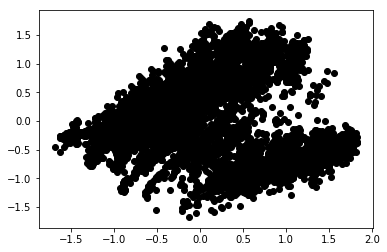

<Figure size 432x288 with 0 Axes>

In [247]:
plot_data(tokenized_one_hots, 'tokenized_plot.jpg')

In [115]:
zip_knn = knn(tokenized_one_hots)

In [117]:
np.save('knn.npy', zip_knn)  

In [237]:
similar = get_closest_neighbors(zip_knn, 'similar.csv')

In [238]:
similar.head(40)

,name,most similar,distance 1,second most similar,distance 2
0,Louis Tomlinson,Jack Huston,3.000000,Burak Deniz,3.000000
1,Freddie Mercury,Seal (musician),3.741657,Akshay Kumar,3.872983
2,Elizabeth II,Nigel Farage,2.645751,"Prince Philip, Duke of Edinburgh",2.828427
3,Stephen Hawking,Jamal Khashoggi,3.316625,Vladimir Lenin,3.316625
4,Donald Trump,John Kasich,3.316625,Elizabeth Dole,3.464102
5,Cristiano Ronaldo,"Pepe (footballer, born 1983)",1.732051,Gary Cahill,2.000000
6,Cardi B,Nicki Minaj,2.645751,Jennifer Lopez,2.645751
7,Elon Musk,Israel Houghton,2.449490,Ellen Page,2.645751
8,XXXTentacion,Remy Ma,3.741657,Daddy Yankee,3.741657
9,Lionel Messi,Javier Mascherano,2.449490,"Willian (footballer, born 1988)",3.000000


In [250]:
print(saved_categories['Barack Obama'])
print(saved_categories['Sarah Palin'])
print(saved_categories['Ron Paul'])

['1961 births', '2008 United States presidential candidates', '2012 United States presidential candidates', '20th-century American male writers', '20th-century American non-fiction writers', '20th-century Protestants', '20th-century scholars', '21st-century American male writers', '21st-century American non-fiction writers', '21st-century American politicians']
['1964 births', '2008 United States vice-presidential candidates', '20th-century American politicians', '20th-century American women politicians', '20th-century Protestants', '21st-century American non-fiction writers', '21st-century American politicians', '21st-century American women politicians', '21st-century American women writers', '21st-century Protestants']
['1935 births', '1988 United States presidential candidates', '2008 United States presidential candidates', '2012 United States presidential candidates', '20th-century American essayists', '20th-century American male writers', '20th-century American physicians', '20th-

In [189]:
## Try grouping with normal categories and it is worse

def count_category_frequency(categories):
    f = {}
    for name in categories:
        for c in categories[name]:
            if 'Articles' not in c and 'Wikidata' not in c and 'CS1' not in c and 'Pages' not in c and 'articles' not in c and 'pages' not in c:
                if c in f:
                    f[c] += 1
                else:
                    f[c] = 1
    return f

In [186]:
frequency = count_category_frequency(categories)

In [187]:
with open('category_frequency.json', 'w') as f10:
    json.dump(frequency, f10)

In [230]:
selected_categories = {key:val for key, val in frequency.items() if val > 6}

In [231]:
print(len(selected_categories))
print(sort_dict(selected_categories))

1437
[('Living people', 1240), ('21st-century American male actors', 1127), ('21st-century American actresses', 1121), ('American male film actors', 1117), ('20th-century American male actors', 1046), ('American male television actors', 902), ('American film actresses', 861), ('20th-century American actresses', 853), ('21st-century American singers', 598), ('American television actresses', 536), ('21st-century women singers', 431), ('20th-century American singers', 389), ('21st-century American comedians', 373), ('American people of Irish descent', 344), ('American people of English descent', 318), ('American male voice actors', 297), ('American child actresses', 297), ('20th-century American comedians', 280), ('American Roman Catholics', 246), ('American people of German descent', 240), ('American male stage actors', 236), ('Infobox person using alma mater', 226), ('21st-century American rappers', 225), ('21st-century English male actors', 222), ('1986 births', 212), ('21st-century Am

In [240]:
pure_one_hots = prepare_data(categories, selected_categories)

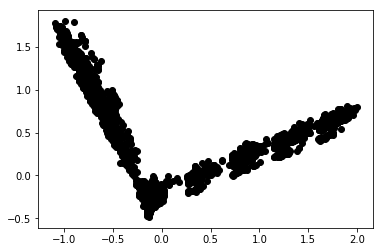

<Figure size 432x288 with 0 Axes>

In [248]:
plot_data(pure_one_hots, 'untokenized.jpg')

In [183]:
zip_knn1 = knn(cat_data)

In [185]:
np.save('zip_knn_cat.npy',zip_knn1)

In [239]:
similar2 = get_closest_neighbors(zip_knn1, 'bad_similar.csv')
similar2.head(40)

# not as accurate as that with tokenized categories

,name,most similar,distance 1,second most similar,distance 2
0,Louis Tomlinson,Caster Semenya,1.732051,Grigor Dimitrov,1.732051
1,Freddie Mercury,Hassanal Bolkiah,2.000000,Carl XVI Gustaf of Sweden,2.000000
2,Elizabeth II,Louis XIV of France,2.236068,Alauddin Khalji,2.236068
3,Stephen Hawking,Jeremy Clarkson,2.828427,Alexander the Great,2.828427
4,Donald Trump,Alexander the Great,2.828427,Elon Musk,2.828427
5,Cristiano Ronaldo,Gary Cahill,1.732051,"Pepe (footballer, born 1983)",1.732051
6,Cardi B,Emmy Rossum,2.645751,Nicki Minaj,2.645751
7,Elon Musk,Peter Madsen,1.414214,Luca Guadagnino,1.414214
8,XXXTentacion,Louis XIV of France,2.828427,Alauddin Khalji,2.828427
9,Lionel Messi,Javier Mascherano,2.000000,Edinson Cavani,2.236068
